# Author Note

Please make sure to read my EDA work before moving to here, as I will not explain the preprocess step again in this notebook

# Load the Data

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/tiki_data')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import *
from collections import Counter
import re

pd.set_option('display.float_format', lambda x: '%.5f' % x)
sns.set_style("darkgrid")

In [ ]:
def load_data(folder_path):
    csv_files = glob.glob(folder_path + "/" + "*.csv")
    dfs = []
    for f in csv_files:
        dfs.append(pd.read_csv(f))

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df.drop_duplicates(subset="id", keep="first", inplace=True)
    combined_df = combined_df.reset_index()
    combined_df.drop('index', axis=1, inplace=True)
    return combined_df

data_1_df = load_data('data_1')
data_2_df = load_data('data_2')
origin_df = pd.concat([data_1_df, data_2_df])

# Preproces the Data

In [ ]:
def flatten_warranty_info(row):
    if pd.notnull(row['warranty_info']):
        vls = row['warranty_info']
        for info in eval(vls):
            column_name = info.get('name')
            column_value = info.get('value')
            if column_name:
                row[column_name] = column_value
    return row

def flatten_inventory(row):
    vls = eval(row['inventory'])
    if pd.notnull(vls):
        row['fulfillment_type'] = vls.get('fulfillment_type')
        return row

def flatten_current_seller(row):
    if pd.notnull(row['current_seller']):
        vls = eval(row['current_seller'])
        row['store_id'] = vls.get('store_id')
        return row

def to_bool_col(df, col_list):
    for c in col_list:
        df[c] = df[c].map(lambda x: 1 if pd.notnull(x) else 0)
    return df

def extract_price_comparison(row):
    if not pd.notnull(row):
        return 0.0

    pattern = r'^Giá từ\s*|\s*₫$'
    number = re.sub(pattern, '', eval(row).get('sub_title'))
    number = re.sub(r'\.', '', number)
    return float(number)

def convert_to_days(value):
    if pd.isnull(value):
        return 0
    elif 'Tháng' in value:
        months = int(value.split()[0])
        return months * 30
    elif 'Năm' in value:
        years = int(value.split()[0])
        return years * 365
    elif 'Ngày' in value:
        days = int(value.split()[0])
        return days
    elif 'trọn đời' in value:
        return 999999999
    else:
        return 0



In [ ]:

def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)

    return multiple_outliers

def preprocessing(df):
    ## Flatten
    df = df.apply(flatten_warranty_info, axis=1)
    df = df.apply(flatten_inventory, axis=1)
    df = df.apply(flatten_current_seller, axis=1)
    df['brand'] = df['brand'].apply(lambda x: eval(x).get('slug') if pd.notnull(x) else 'none')
    df['quantity_sold'] = df['quantity_sold'].apply(lambda x: eval(x).get('value') if pd.notnull(x) else 0)


    ## Drop unuse cols
    cols_to_drop = ['description', 'add_on_title', 'badges', 'promitions', 'configurable_options', 'warranty_info', 'current_seller', 'authors', 'configurable_products',
                    'asa_cashback_widget', 'breadcrumbs', 'categories', 'installment_info_v2', 'specifications', 'badges_new', 'Nơi bảo hành', 'all_time_quantity_sold',
                    'Hướng dẫn bảo hành', 'inventory','gift_item_title', 'stock_item', 'return_and_exchange_policy', 'product_links', 'add_on', 'benefits',
                    'add_on', 'benefits', 'name', 'other_sellers', 'review_text', 'short_description', 'sku']
    df = df.drop(cols_to_drop, axis=1).reset_index(drop=True)


    ## Convert columns to boolean values
    to_bool_cols = ['video_url', 'Hình thức bảo hành']
    df = to_bool_col(df, to_bool_cols)
    df = df.rename(columns={'video_url': 'has_video_url', 'Hình thức bảo hành': 'has_warranty_method'})


    ## Apply some functions
    df['num_other_seller'] = df['price_comparison'].apply(
        lambda x: int(re.findall(r'\d+', eval(x).get('title'))[0]) if pd.notnull(x) else 0)
    df['price_comparison'] = df['price_comparison'].apply(extract_price_comparison)
    df['warranty_days'] = df['Thời gian bảo hành'].apply(convert_to_days)
    df = df.drop('Thời gian bảo hành', axis=1).reset_index(drop=True)


    percent_threshold = 95
    percentage_null = (df.isnull().sum() / len(df)) * 100
    percentage_null = percentage_null[percentage_null > percent_threshold]
    df = df.drop(percentage_null.index, axis=1)

    percent_threshold = 5
    percentage_null = (df.isnull().sum() / len(df)) * 100
    cols_have_low_percentage_null = percentage_null[percentage_null < percent_threshold]
    cols_have_low_percentage_null = cols_have_low_percentage_null[cols_have_low_percentage_null > 0]
    df = df.dropna(subset=cols_have_low_percentage_null.index).reset_index(drop=True)


    df = df.dropna(subset=['original_price'], axis=0).reset_index(drop=True)



    ## Remove outliers
    numerical_cols = ['day_ago_created', 'discount', 'discount_rate', 'list_price',
                    'original_price', 'price', 'price_comparison', 'quantity_sold',
                    'review_count', 'num_other_seller', 'warranty_days']
    print('outliers detected:', len(df.loc[detect_outliers(df, numerical_cols)]))
    df = df.drop(detect_outliers(df, numerical_cols), axis=0).reset_index(drop=True)


    ## Drop columns that have just one unique value
    columns_to_drop = []
    for column in df.columns:
        if df[column].nunique() == 1:
            columns_to_drop.append(column)
    df = df.drop(columns_to_drop, axis=1)


    return df

df = origin_df.copy()
df = preprocessing(df)

outliers detected: 49390


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116441 entries, 0 to 116440
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   has_warranty_method  116441 non-null  int64  
 1   brand                116441 non-null  object 
 2   day_ago_created      116441 non-null  float64
 3   discount             116441 non-null  float64
 4   discount_rate        116441 non-null  float64
 5   id                   116441 non-null  float64
 6   inventory_type       116441 non-null  object 
 7   list_price           116441 non-null  float64
 8   master_id            116441 non-null  float64
 9   original_price       116441 non-null  float64
 10  price                116441 non-null  float64
 11  price_comparison     116441 non-null  float64
 12  quantity_sold        116441 non-null  int64  
 13  rating_average       116441 non-null  float64
 14  review_count         116441 non-null  float64
 15  type             

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def get_train_test(df, target, test_size=0.2, random_state=42, scale=True):
    le = preprocessing.LabelEncoder()
    df = df.apply(le.fit_transform)

    X = df.drop(target, axis=1)
    y = df[target].values

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if scale:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        return le, scaler, (X_train, X_test, y_train, y_test)

    return le, (X_train, X_test, y_train, y_test)

temp_df = df.copy()

# Recommendation
In the context of Ecommerce, **Recommendation System** is the first one come into my mind, it provides personalized recommendations based on user behavior or product features, collaborative filtering or matrix factorization techniques can be employed.

Unfortunately our dataset does not support this purpose, we just have the basic products information (price, quantity sold, description, ...), if we want to develop a Recommendation System, we need information such as user behavior, user purchasing history, or more indepth product information such as which other products are usually bought with, for example people purchase books  has 37%  will purchase pen,  13% will purchase school bag, ...

For those reason, I will not develop a Recommendation System in this project.

# Regression

> Before making a Machine Learning model, we have to think what problem the model is trying to solve. **Is it worth it**? Will it widely used?<br/>In my perspective, Regression is not a best choice in the context of Ecommerce, especially with our dataset.

We can consider to develop a regression model to predict a continuous variable, such as `price` or `quantity_sold` by using Machine Learning algorithms such as Linear Regression, Decision Tree or Random Forest Regression.

- In reality, `price` of a product doesn't rely much on our features we currently have (more review or quantity sold can't increase a product price), we instead need technology information, materials used for making the product, product is handmade or industrial, etc.. And **WHY WE HAVE TO PREDICT A VALUE WHICH IS EXISTING?** Tiki just sells products which are already released such as Iphone, clothes,... and most of sellers here are retailers, they just set the price whatever they want, and whether customers buy or not is up to them.

- For the `quantity_sold`, this is not a good choice to be marked as target,because quantity sold is increasing day by day, until it reach out of stock, It is not worth to build a model to predict this feature. We can try to predict `quanty_sold` for next 30 days, but the feature `created_day_ago` of our dataset varied, it requires a lot of effort to develop such model.

- We can try to predict `warranty_days`, but again it is not worth to build such model. No one cares how long the product is warranted for, because that information is always announced at the time the product release. Anyways, because this problem is easy to approach, I will try to make a model that predict `wanrranty_days`, maybe it useful in the case the seller forget attaching the number of warranty days.

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

le, scaler, (X_train, X_test, y_train, y_test) = get_train_test(temp_df, target='warranty_days')
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 3.2446706740240345


3.24 is an acceptable number for our model

# Classification

I think our dataset is not suitable for classification tasks
- Dataset is not balance
- Lack of features
- Not a good choice in the context of Tiki Ecommerce

In [17]:
temp_df = df.copy()
cols_for_classification = []
for c in temp_df.columns:
    if len(temp_df[c].unique()) < 10:
        print(c, temp_df[c].unique())
        cols_for_classification.append(c)

has_warranty_method [0 1]
inventory_type ['backorder' 'instock']
type ['simple' 'configurable']
has_video_url [0 1]
fulfillment_type ['seller_delivery' 'dropship' 'tiki_delivery' 'cross_border'
 'instant_delivery' '']


These are columns that can be used as target (label) for classification task

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

for c in cols_for_classification:
    le, scaler, (X_train, X_test, y_train, y_test) = get_train_test(temp_df, target=c)

    model = LogisticRegression(solver='lbfgs', max_iter=2000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'target column: {c} -- acc: {acc:.3f}')

target column: has_warranty_method -- acc: 0.978
target column: inventory_type -- acc: 1.000
target column: type -- acc: 0.613
target column: has_video_url -- acc: 0.928
target column: fulfillment_type -- acc: 0.898


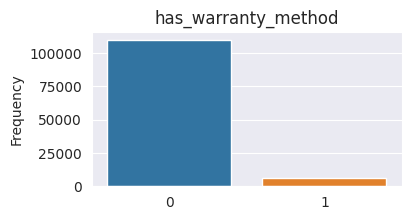

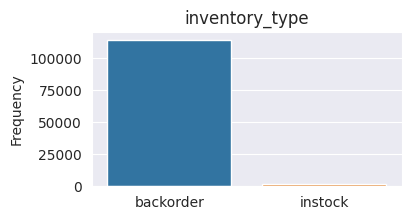

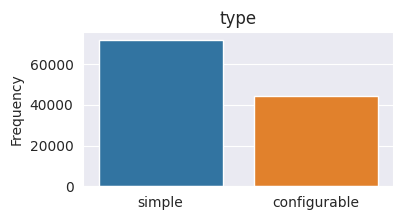

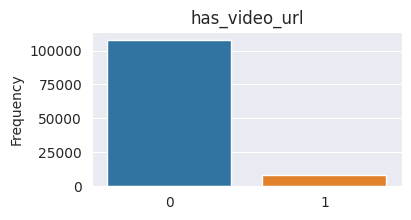

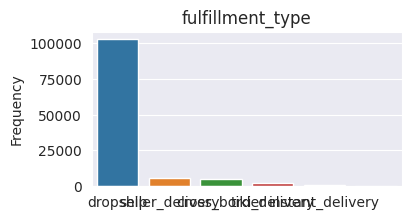

In [19]:
for c in cols_for_classification:
    count = temp_df[c].value_counts()
    plt.figure(figsize = (4,2))
    sns.barplot(x=count.index, y=count)
    plt.ylabel("Frequency")
    plt.title(c)
    plt.show()

If we look at those chart above, we could easily see that their values is extremely imbalanced. Most of our prediction get very high accuracy due to this problem, for example we want to predict `has_warranty_method`, if our model just always predict as 0, the accuracy will always higher than 90% because more than 90% of our product does not have warranty_method.

For the `type` classification, we just get 60% accuracy because the value of `tye` column is not imbalance, that low accuracy could be due to the lack of data, or the model is not well trained

# Clustering

Clustering perhaps considered as best choice for our dataset.

The purpose of the clustering task in the ecommerce context, using the given product dataset, is to identify natural groupings or clusters within the data based on the provided features. Clustering helps to discover patterns, similarities, and structures in the dataset without any predefined class labels.

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Preprocess the data
le = preprocessing.LabelEncoder()
new_df = temp_df.apply(le.fit_transform)
new_df = scaler.fit_transform(new_df)

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
new_df = pca.fit_transform(new_df)

# Clustering using K-means
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(new_df)
cluster_labels = kmeans.labels_

# Evaluate clustering quality using silhouette score
silhouette_avg = silhouette_score(new_df, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Analyze and interpret the clusters
temp_df['cluster_label'] = cluster_labels
cluster_counts = df['cluster_label'].value_counts()
print("Cluster Counts:")
print(cluster_counts)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.38968875621389576
Cluster Counts:
1    43152
2    38757
0    34532
Name: cluster_label, dtype: int64


Silhouette Score typically ranges between -1 and 1, with higher values indicating better clustering results.

In our case, the Silhouette Score of 0.389688520648102 suggests that the clusters have some degree of separation but may not be well-defined or distinct. It is considered a moderate score.

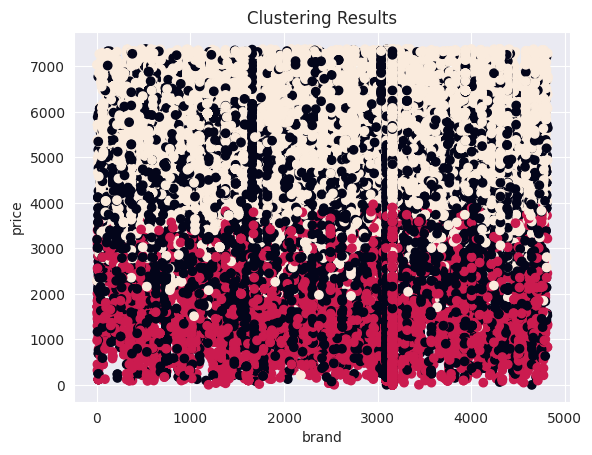

In [85]:
le = preprocessing.LabelEncoder()
temp = temp_df.apply(le.fit_transform)
plt.scatter('brand', 'price', data=temp, c=cluster_labels)
plt.xlabel('brand')
plt.ylabel('price')
plt.title('Clustering Results')
plt.show()

It is easy to see brands in red only produce products in a specific price range, which is considered low price range.

Black brands scattered everywhere, but their mostly price range is middle

The rest are brands sell high price products

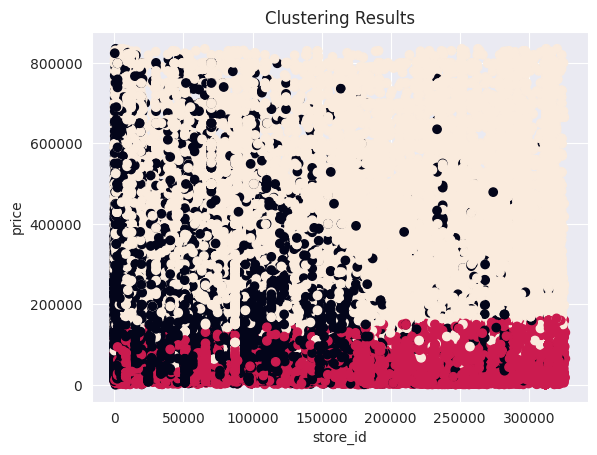

In [81]:
plt.scatter('store_id', 'price', data=temp_df, c=cluster_labels)
plt.xlabel('store_id')
plt.ylabel('price')
plt.title('Clustering Results')
plt.show()

The same for store, stores in red color just sell cheap products, the one in beige color sell higher price products

# Cluster popular stores

Group dataset by store_id and do clustering to divide into multiple kind of store. Cluster where stores have high rating, high quantity sold, high review count are popular cluster. We can use these store_id for next time crawling, because the products of these store are often become popular.

In [76]:
grouped_data = temp_df.groupby('store_id').agg({'rating_average': 'mean', 'quantity_sold': 'sum', 'review_count': 'sum', })

data = grouped_data.values.reshape(-1, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data)

grouped_data = grouped_data.reset_index()
grouped_data['store_kind'] = kmeans.labels_

grouped_data[(grouped_data['store_kind'] == 2) | (grouped_data['store_kind'] == 1)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,store_id,rating_average,quantity_sold,review_count,store_kind
3,44.00000,2.57209,5248,124.00000,2
27,157.00000,2.49116,6191,981.00000,2
31,167.00000,1.82484,5123,116.00000,2
178,1248.00000,3.25526,6878,672.00000,2
180,1252.00000,3.98421,22232,1091.00000,2
377,3297.00000,4.50000,6813,546.00000,2
408,3786.00000,1.75045,7158,1230.00000,2
487,4946.00000,2.12164,9988,2205.00000,2
525,5562.00000,3.22034,11679,1491.00000,2
529,5588.00000,2.28889,5619,163.00000,2
